# Imports

In [2]:
import mlflow.sklearn

In [84]:
import pandas as pd
import numpy as np
import missingno as msno
import time
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from contextlib import contextmanager
import statsmodels.api as sm

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [6]:
# librairies pour ne pas afficher les warning
import warnings
warnings.filterwarnings('ignore')

In [7]:
np.random.seed(0)

In [8]:
pd.options.display.max_columns = 200

In [9]:
mlflow.set_tracking_uri('http://127.0.0.1:5000/')

# Fonctions 

In [10]:
def data_duplicated(df):
    '''Retourne le nombre de lignes identiques.'''
    return df.duplicated(keep=False).sum()

def row_duplicated(df,col):
    '''Retourne le nombre de doublons de la variable col.'''
    return df.duplicated(subset = col, keep='first').sum()

def missing_cells(df):
    '''Calcule le nombre de cellules manquantes sur le data set total'''
    return df.isna().sum().sum()

def missing_cells_perc(df):
    '''Calcule le pourcentage de cellules manquantes sur le data set total'''
    return df.isna().sum().sum()/(df.size)

def missing_general(df):
    '''Donne un aperçu général du nombre de données manquantes dans le data frame'''
    print('Nombre total de cellules manquantes :',missing_cells(df))
    print('Nombre de cellules manquantes en % : {:.2%}'.format(missing_cells_perc(df)))

def valeurs_manquantes(df):
    '''Prend un data frame en entrée et créer en sortie un dataframe contenant le nombre de valeurs manquantes
    et leur pourcentage pour chaque variable. '''
    tab_missing = pd.DataFrame(columns = ['Variable', 'Missing values', 'Missing (%)'])
    tab_missing['Variable'] = df.columns
    missing_val = list()
    missing_perc = list()

    for var in df.columns:
        nb_miss = missing_cells(df[var])
        missing_val.append(nb_miss)
        perc_miss = missing_cells_perc(df[var])
        missing_perc.append(perc_miss)

    tab_missing['Missing values'] = list(missing_val)
    tab_missing['Missing (%)'] = list(missing_perc)
    return tab_missing

def bar_missing(df):
    '''Affiche le barplot présentant le nombre de données présentes par variable.'''
    msno.bar(df)
    plt.title('Nombre de données présentes par variable', size=15)
    plt.show()

def barplot_missing(df):
    '''Affiche le barplot présentant le pourcentage de données manquantes par variable.'''
    proportion_nan = df.isna().sum().divide(df.shape[0]/100).sort_values(ascending=False)
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 30))
    ax = sns.barplot(y = proportion_nan.index, x=proportion_nan.values)
    plt.title('Pourcentage de données manquantes par variable', size=15)
    plt.show()

def drop_columns_empty(df,lim):
    '''Prend en entrée un data frame et un seuil de remplissage de données.
    Supprime chaque variable ayant un pourcentage de données manquantes supérieur à celui renseigné.
    Donne en sortie le data frame filtré avec les colonnes à garder.'''

    tab = valeurs_manquantes(df)
    columns_keep = list()
    for row in tab.iterrows():
        if float(row[1]['Missing (%)'])>float(lim):
            print('Suppression de la variable {} avec % de valeurs manquantes {}'.format(row[1]['Variable'],
                                                                                         round(float(row[1]['Missing (%)']),2)))

        else :
            columns_keep.append(row[1]['Variable'])

    return df[columns_keep]

def drop_columns_empty(df,lim):
    '''Prend en entrée un data frame et un seuil de remplissage de données.
    Supprime chaque variable ayant un pourcentage de données manquantes supérieur à celui renseigné.
    Donne en sortie le data frame filtré avec les colonnes à garder.'''

    tab = valeurs_manquantes(df)
    columns_keep = list()
    for row in tab.iterrows():
        if float(row[1]['Missing (%)'])>float(lim):
            print('Suppression de la variable {} avec % de valeurs manquantes {}'.format(row[1]['Variable'],
                                                                                         round(float(row[1]['Missing (%)']),2)))

        else :
            columns_keep.append(row[1]['Variable'])

    return df[columns_keep]

def boxplot(df,ylim):
    ''' Affiche une fenêtre contenant tous les boxplots des variables sélectionnées'''
    fig = plt.figure(figsize=(20, 15))
    ax = plt.axes()
    plt.xticks(rotation=90)
    ax.set_ylim(ylim)
    sns.boxplot(data=df)
    plt.title('Boxplot des variables', size=15)

def multi_boxplot(df):
    ''' Affiche indépendamment tous les boxplots des variables sélectionnées'''
    fig, axs = plt.subplots(4,3,figsize=(20,20))
    axs = axs.ravel()

    for i,col in enumerate(df.columns):
        sns.boxplot(x=df[col], ax=axs[i])
    fig.suptitle('Boxplot pour chaque variable quantitative')
    plt.show()

def distribution(df,colonnes,n_cols,nom,fig=(20,20)):
    ''' Affiche les histogrammes pour chaque variable renseignée.'''
    n_rows = int(len(colonnes)/n_cols)+1
    fig = plt.figure(figsize=fig)
    for i, col in enumerate(colonnes,1):
        ax = fig.add_subplot(n_rows,n_cols,i)
        sns.histplot(data=df, x=col, bins=30, kde=True, ax=ax)

    plt.tight_layout(pad = 2)
    plt.savefig(nom)
    plt.show()

def bar_plot(df,colonnes,n_cols,nom,fig=(20,20)):
    ''' Affiche les bar plots pour chaque variable renseignée.'''
    fig = plt.figure(figsize=fig)
    n_rows = int(np.ceil(len(colonnes)/n_cols))
    for i, col in enumerate(colonnes,1):
        ax = fig.add_subplot(n_rows,n_cols,i)
        count = df[col].value_counts()
        count.plot(kind="bar", ax=ax, fontsize=20, rot=90)
        ax.set_title(col, fontsize = 20)
    plt.tight_layout(pad = 2)
    plt.savefig(nom)
    plt.show()

def bar_plot_stacked(df,colonnes,n_cols,nom,fig=(20,20)):
    ''' Affiche les bar plots pour chaque variable renseignée décomposés en fonction de var2.'''
    fig = plt.figure(figsize=fig)
    n_rows = int(np.ceil(len(colonnes)/n_cols))
    for i, col in enumerate(colonnes,1):
        ax = fig.add_subplot(n_rows,n_cols,i)
        count = pd.DataFrame(df.groupby(col)['TARGET'].value_counts()).reset_index()
        count = count.pivot_table(index=col, columns = 'TARGET', values = 'count')
        #count = pd.crosstab(index=count[col], columns =count[var2], values = 'count')
        count.plot(kind="bar", stacked=True, ax=ax, fontsize=20, rot=90)
        ax.set_title(col, fontsize = 20)
        ax.legend(['rembourse','défaut'],fontsize = 20)
    plt.tight_layout(pad = 2)
    plt.savefig(nom)
    plt.show()

def pie_plot(df,colonnes):
    '''Affiche un pie plot présentant la répartition de la variable renseignée.'''
    for col in colonnes :
        labels = list(df[col].value_counts().sort_index().index.astype(str))
        count = df[col].value_counts().sort_index()

        plt.figure(figsize=(5, 5))
        plt.pie(count,autopct='%1.2f%%')
        plt.title('Répartition de {}'.format(col), size = 20)
        plt.legend(labels)
        plt.show()

def distribution_densite(df,colonnes,n_cols,nom,fig=(20,20)):
    ''' Affiche les densités pour chaque variable renseignée.'''
    n_rows = int(len(colonnes)/n_cols)+1
    fig = plt.figure(figsize=fig)
    for i, col in enumerate(colonnes,1):
        ax = fig.add_subplot(n_rows,n_cols,i)
        sns.kdeplot(df.loc[df['TARGET'] == 0, col], label = 'rembourse')
        sns.kdeplot(df.loc[df['TARGET'] == 1, col], label = 'défaut')
        ax.set_xlabel(col, fontsize=20)
        ax.set_ylabel('Density', fontsize=20)
        ax.legend(fontsize=20)
        ax.set_title('Distribution of '+col, fontsize=20)

    plt.tight_layout(pad = 2)
    plt.savefig(nom)
    plt.show()

def scatter_plot(df,colonnes,var_comparaison, largeur, longueur):
    ''' Affiche le scatter plot des variables quantitatives.'''
    fig = plt.figure(figsize=(15,15))
    for i,col in enumerate(colonnes,1):
        X = df[[var_comparaison]]
        Y = df[col]
        X = X.copy()
        X['intercept'] = 1.
        result = sm.OLS(Y, X).fit()
        a,b = result.params[var_comparaison],result.params['intercept']
        equa = "y = " + str(round(a,2)) + " x + " + str(round(b,0))

        ax = fig.add_subplot(longueur,largeur,i)
        plt.scatter(x=df[var_comparaison], y=df[col])
        plt.plot(range(-15,41),[a*x+b for x in range(-15,41)],label=equa,color='red')
        ax.set_xlabel(xlabel=var_comparaison)
        ax.set_ylabel(ylabel=col)
        plt.legend()
    plt.tight_layout(pad = 4)
    fig.suptitle("Scatter plot des variables quantitatives")
    plt.show()

def heat_map(df_corr):
    '''Affiche la heatmap '''
    plt.figure(figsize=(30,30))
    sns.heatmap(df_corr, annot=True, linewidth=.5)
    plt.title("Heatmap")

def boxplot_relation(df,colonnes,var_comparaison,longueur,largeur, ordre=None,outliers=True,option=False):
    '''Affiche les boxplot des colonnes en fonctions de var_comparaison.'''
    fig = plt.figure(figsize=(20,30))
    for i,col in enumerate(colonnes,1):
        ax = fig.add_subplot(longueur,largeur,i)
        sns.boxplot(x=df[var_comparaison],y=df[col], ax=ax, order=ordre, showfliers = outliers)
        if option:
            plt.xticks(rotation=90, ha='right')
    fig.suptitle('Boxplot de chaque target en fonction de {}'.format(var_comparaison))
    plt.tight_layout(pad = 4)
    plt.show()


In [13]:
@contextmanager
def timer(title):
    '''Fonction calculant le temps d'exécution d'autres fonctions.
    Keyword arguments:
    title -- titre de la fonction exécutée.
    '''
    t0 = time.time()
    yield
    print("{} - réalisé en {:.0f}s".format(title, time.time() - t0))

def one_hot_encoder(df, nan_as_category = True):
    '''Encodage des variables catégorielles.
    Keyword arguments:
    df -- dataframe
    nan_as_category -- ajout d'une colonne indiquant les NaN (default True)
    Returns:
    df -- dataframe encodé
    new_columns -- nouvelles colonnes créées par l'encodage.
    '''
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category, dtype=int)
    new_columns = [c for c in df.columns if c not in original_columns]

    return df, new_columns

def application_train_test(num_rows = None, nan_as_category = False):
    '''Preprocessing de application_train.csv et application_test.csv.
    Keyword arguments:
    num_rows -- nombre de lignes (default None)
    nan_as_category -- ajout d'une colonne indiquant les NaN (default False)
    Returns:
    df -- dataframe mergé et preprocessing réalisé.
    '''
    # Read data and merge
    df = pd.read_csv('input/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('input/application_test.csv', nrows= num_rows)
    print("Taille des données d'entrainement: {}, Taille des données de test: {}".format(len(df), len(test_df)))
    df = pd.concat([df,test_df], ignore_index=True)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    del test_df
    gc.collect()

    return df

def bureau_and_balance(num_rows = None, nan_as_category = True):
    '''Preprocessing de bureau.csv et bureau_balance.csv.
    Keyword arguments:
    num_rows -- nombre de lignes (default None)
    nan_as_category -- ajout d'une colonne indiquant les NaN (default True)
    Returns:
    bureau_agg -- dataframe aggregé et preprocessing réalisé.
    '''
    bureau = pd.read_csv('input/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('input/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()

    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()

    return bureau_agg

def previous_applications(num_rows = None, nan_as_category = True):
    '''Preprocessing de previous_applications.csv.
    Keyword arguments:
    num_rows -- nombre de lignes (default None)
    nan_as_category -- ajout d'une colonne indiquant les NaN (default True)
    Returns:
    prev_agg -- dataframe aggregé et preprocessing réalisé.
    '''
    prev = pd.read_csv('input/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()

    return prev_agg

def pos_cash(num_rows = None, nan_as_category = True):
    '''Preprocessing de POS_CASH_balance.csv.
    Keyword arguments:
    num_rows -- nombre de lignes (default None)
    nan_as_category -- ajout d'une colonne indiquant les NaN (default True)
    Returns:
    pos_agg -- dataframe aggregé et preprocessing réalisé.
    '''
    pos = pd.read_csv('input/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)

    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()

    return pos_agg

def installments_payments(num_rows = None, nan_as_category = True):
    '''Preprocessing de installments_payments.csv.
    Keyword arguments:
    num_rows -- nombre de lignes (default None)
    nan_as_category -- ajout d'une colonne indiquant les NaN (default True)
    Returns:
    ins_agg -- dataframe aggregé et preprocessing réalisé.
    '''
    ins = pd.read_csv('input/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)

    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()

    return ins_agg

def credit_card_balance(num_rows = None, nan_as_category = True):
    '''Preprocessing de credit_card_balance.csv.
    Keyword arguments:
    num_rows -- nombre de lignes (default None)
    nan_as_category -- ajout d'une colonne indiquant les NaN (default True)
    Returns:
    cc_agg -- dataframe aggregé et preprocessing réalisé.
    '''
    cc = pd.read_csv('input/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)

    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()

    return cc_agg

In [14]:
num_rows = None
df = application_train_test(num_rows)

with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()

Taille des données d'entrainement: 307511, Taille des données de test: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - réalisé en 18s
Previous applications df shape: (338857, 249)
Process previous_applications - réalisé en 19s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - réalisé en 10s
Installments payments df shape: (339587, 26)
Process installments payments - réalisé en 24s
Credit card balance df shape: (103558, 141)
Process credit card balance - réalisé en 16s


In [15]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Taille des données d'entrainement: {}".format(len(train_df)))
print("Taille des données de test: {}".format(len(test_df)))

Taille des données d'entrainement: 307507
Taille des données de test: 48744


In [16]:
#train_df.to_csv('train_df.csv', index = False)
#test_df.to_csv('test_df.csv', index = False)

In [17]:
print("Taille du jeu d'entrainement: {}".format(train_df.shape))
print("Taille du jeu de test: {}".format(test_df.shape))

Taille du jeu d'entrainement: (307507, 797)
Taille du jeu de test: (48744, 797)


In [18]:
print("Nombre de lignes dupliquées dans le jeu d'entrainement: {}".format(data_duplicated(train_df)))
print("Nombre de lignes dupliquées dans le jeu de test: {}".format(data_duplicated(test_df)))

Nombre de lignes dupliquées dans le jeu d'entrainement: 0
Nombre de lignes dupliquées dans le jeu de test: 0


In [19]:
print('Le dataset train :')
missing_general(train_df)
print()
print('Le dataset test :')
missing_general(test_df)

Le dataset train :
Nombre total de cellules manquantes : 63543491
Nombre de cellules manquantes en % : 25.93%

Le dataset test :
Nombre total de cellules manquantes : 8556450
Nombre de cellules manquantes en % : 22.02%


In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307507 entries, 0 to 307510
Columns: 797 entries, SK_ID_CURR to CC_COUNT
dtypes: float64(622), int32(133), int64(42)
memory usage: 1.7 GB


In [91]:
train_df = drop_columns_empty(train_df,0.5)

In [92]:
train_df.shape

(307507, 561)

In [23]:
test_df = test_df[train_df.columns]
print(test_df.shape)

(48744, 561)


In [24]:
train_df['DAYS_BIRTH'].describe()

count    307507.000000
mean     -16037.027271
std        4363.982424
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

In [25]:
(train_df['DAYS_BIRTH']/-365).describe()

count    307507.000000
mean         43.937061
std          11.956116
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [26]:
train_df['DAYS_BIRTH'] = train_df['DAYS_BIRTH']/-365
test_df['DAYS_BIRTH'] = test_df['DAYS_BIRTH']/-365

In [27]:
# change les valeurs négatives en valeurs positives.
train_df[train_df.columns[(train_df < 0).any()].tolist()] = train_df[train_df.columns[(train_df < 0).any()].tolist()]*-1

test_df[test_df.columns[(test_df < 0).any()].tolist()] = test_df[test_df.columns[(test_df < 0).any()].tolist()]*-1

In [28]:
train_df['DAYS_ID_PUBLISH'] = train_df['DAYS_ID_PUBLISH'].astype(float)
test_df['DAYS_ID_PUBLISH'] = test_df['DAYS_ID_PUBLISH'].astype(float)

In [29]:
train_df['DAYS_EMPLOYED'].describe()

count    252133.000000
mean       2384.142254
std        2338.327666
min          -0.000000
25%         767.000000
50%        1648.000000
75%        3175.000000
max       17912.000000
Name: DAYS_EMPLOYED, dtype: float64

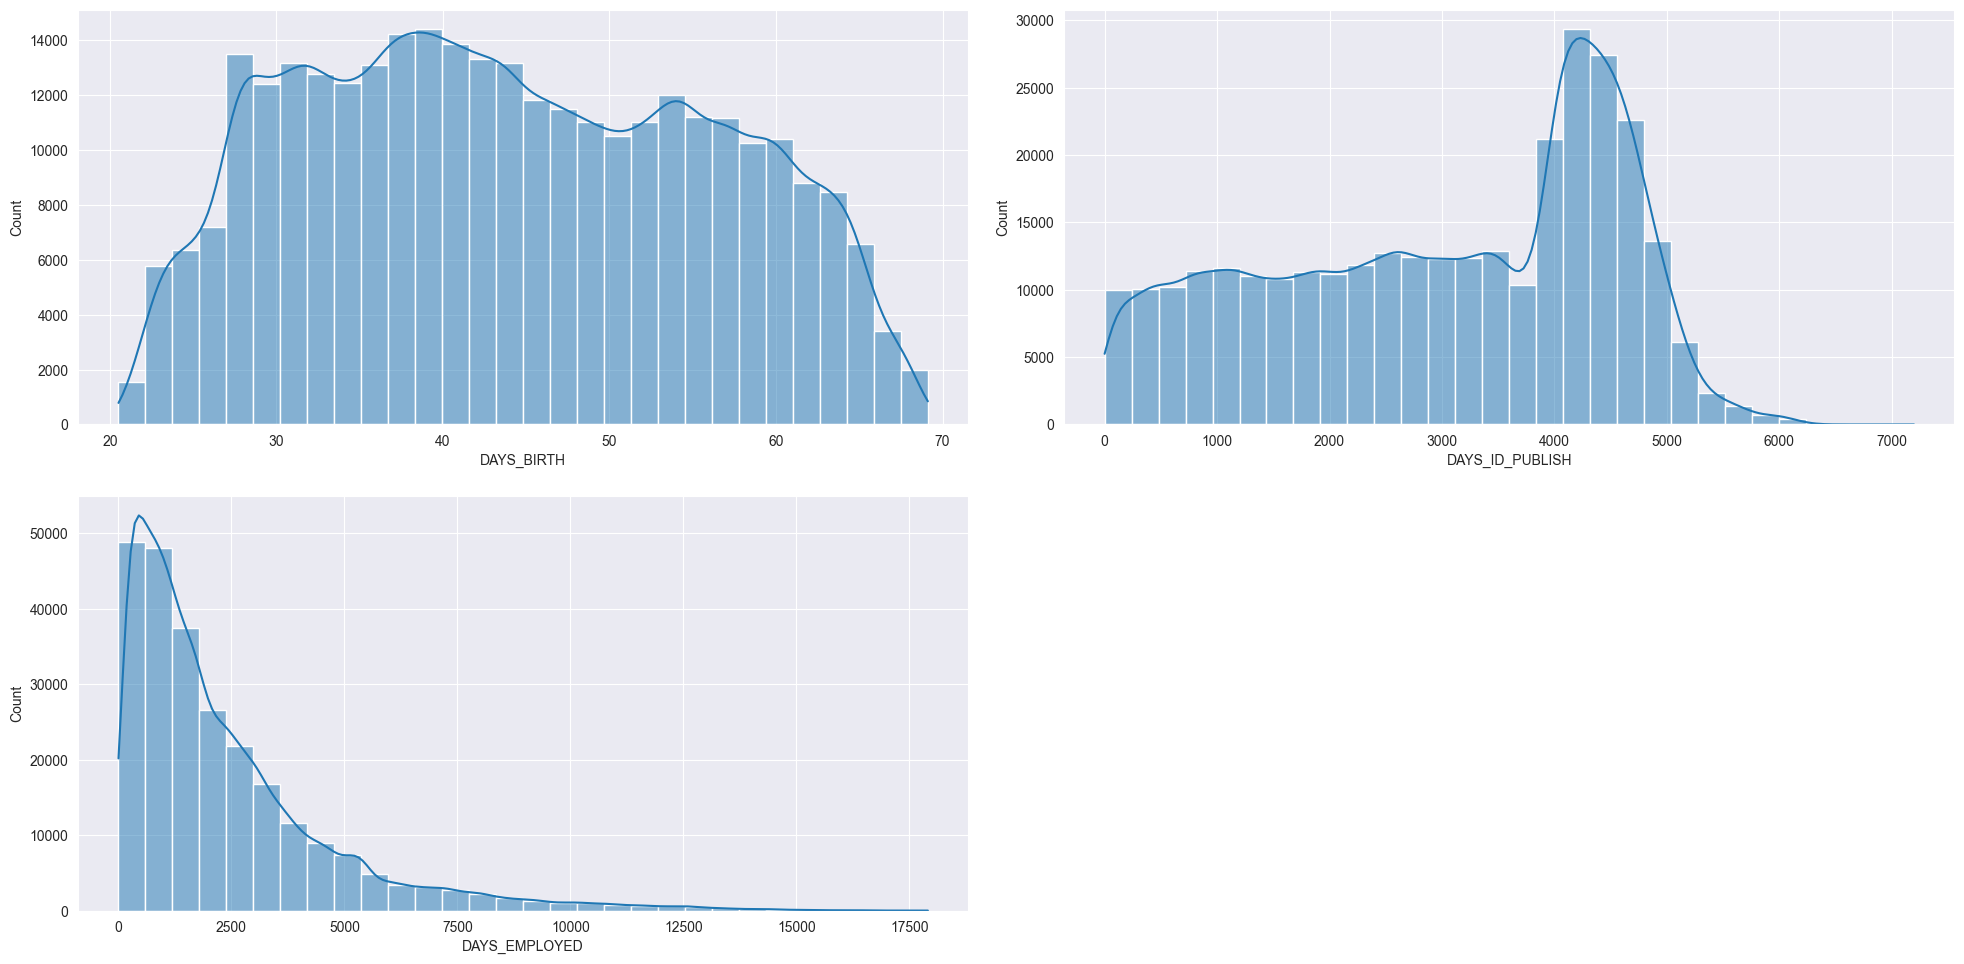

In [31]:
distribution(train_df,['DAYS_BIRTH','DAYS_ID_PUBLISH','DAYS_EMPLOYED'],
                n_cols=2, nom='histo_3.pdf', fig=(20,10))

In [32]:
train_df['TARGET'] = train_df['TARGET'].astype(int)

In [33]:
test_df = test_df.drop('TARGET',axis=1)

In [34]:
train_df = train_df.replace(np.inf, np.nan)
test_df = test_df.replace(np.inf, np.nan)

In [35]:
#train_df.to_csv('train_df_nan.csv', index = False)
#test_df.to_csv('test_df_nan.csv', index = False)

# Imputations

Imputons désormais nos données. Nous allons appliquer différentes méthodes d'imputation simples. Tout d'abord, pour les colonnes qui proviennent de l'agrégation, nous allons remplacer les valeurs manquantes par 0.0. Pour les variables quantitatives restantes, nous remplacerons par la médiane. Enfin, pour les variables qualitatives/catégorielles, nous remplacerons par le mode *(soit la valeur la plus fréquente)*.


In [37]:
quanti_col = train_df.select_dtypes(['float64']).columns
quali_col = train_df.select_dtypes(['int64']).columns
#quali_col = quali_col.drop('TARGET')

In [38]:
# imputation des variables quantitatives issues de l'agrégation
col_agg = train_df.columns[train_df.columns.str.contains('_MIN|_MAX|_MEAN|_VAR|_SUM|_SIZE')]

train_df[col_agg] = train_df[col_agg].fillna(0.0)
test_df[col_agg] = test_df[col_agg].fillna(0.0)

In [39]:
# imputation des variables quantitatives restantes
quanti_col_rest = [col for col in quanti_col if col not in col_agg]
for col in quanti_col_rest:
    median = train_df[col].median()
    train_df[col] = train_df[col].fillna(median)
    test_df[col] = test_df[col].fillna(median)

In [40]:
# imputation des variables qualitatives
for col in quali_col:
    mode = train_df[col].mode()[0]
    train_df[col] = train_df[col].fillna(mode)
    test_df[col] = test_df[col].fillna(mode)

In [41]:
print('Le dataset train :')
missing_general(train_df)
print()
print('Le dataset test :')
missing_general(test_df)

Le dataset train :
Nombre total de cellules manquantes : 0
Nombre de cellules manquantes en % : 0.00%

Le dataset test :
Nombre total de cellules manquantes : 0
Nombre de cellules manquantes en % : 0.00%


In [42]:
#train_df.to_csv('train_df_cleaned.csv', index = False)
#test_df.to_csv('test_df_cleaned.csv', index = False)

In [43]:
train_df.describe()

SK_ID_CURR        TARGET    CODE_GENDER   FLAG_OWN_CAR  \
count  307507.000000  307507.00000  307507.000000  307507.000000   
mean   278181.527256       0.08073       0.658352       0.340106   
std    102790.132982       0.27242       0.474263       0.473745   
min    100002.000000       0.00000       0.000000       0.000000   
25%    189146.500000       0.00000       0.000000       0.000000   
50%    278203.000000       0.00000       1.000000       0.000000   
75%    367143.500000       0.00000       1.000000       1.000000   
max    456255.000000       1.00000       1.000000       1.000000   

       FLAG_OWN_REALTY   CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count    307507.000000  307507.000000      3.075070e+05  3.075070e+05   
mean          0.306331       0.417047      1.687977e+05  5.990286e+05   
std           0.460970       0.722119      2.371246e+05  4.024926e+05   
min           0.000000       0.000000      2.565000e+04  4.500000e+04   
25%           0.000000       0.000000      1.125000e+05  2.700000e+05   
50%           0.000000       0.000000      1.471500e+05  5.135310e+05   
75%           1.000000       1.000000      2.025000e+05  8.086500e+05   
max           1.000000      19.000000      1.170000e+08  4.050000e+06   

         AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
count  307507.000000     3.075070e+05               307507.000000   
mean    27108.580714     5.383178e+05                    0.020868   
std     14493.522125     3.692898e+05                    0.013831   
min      1615.500000     4.050000e+04                    0.000290   
25%     16524.000000     2.385000e+05                    0.010006   
50%     24903.000000     4.500000e+05                    0.018850   
75%     34596.000000     6.795000e+05                    0.028663   
max    258025.500000     4.050000e+06                    0.072508   

          DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
count  307507.000000  307507.000000      307507.000000    307507.000000   
mean       43.937061    2251.582211        4986.131376      2994.201670   
std        11.956116    2136.160141        3522.883030      1509.454566   
min        20.517808      -0.000000          -0.000000         0.000000   
25%        34.008219     933.000000        2010.000000      1720.000000   
50%        43.150685    1648.000000        4504.000000      3254.000000   
75%        53.923288    2760.000000        7479.500000      4299.000000   
max        69.120548   17912.000000       24672.000000      7197.000000   

          FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
count  307507.000000   307507.000000    307507.000000     307507.000000   
mean        0.999997        0.819887         0.199358          0.998133   
std         0.001803        0.384282         0.399518          0.043164   
min         0.000000        0.000000         0.000000          0.000000   
25%         1.000000        1.000000         0.000000          1.000000   
50%         1.000000        1.000000         0.000000          1.000000   
75%         1.000000        1.000000         0.000000          1.000000   
max         1.000000        1.000000         1.000000          1.000000   

          FLAG_PHONE     FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  307507.000000  307507.000000    307507.000000         307507.000000   
mean        0.281057       0.056721         2.152657              2.052461   
std         0.449516       0.231308         0.910677              0.509034   
min         0.000000       0.000000         1.000000              1.000000   
25%         0.000000       0.000000         2.000000              2.000000   
50%         0.000000       0.000000         2.000000              2.000000   
75%         1.000000       0.000000         3.000000              2.000000   
max         1.000000       1.000000        20.000000              3.000000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \

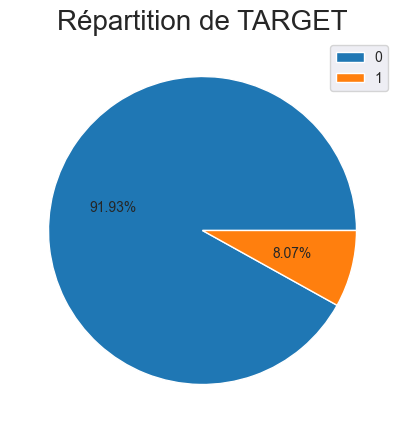

In [44]:
pie_plot(train_df,['TARGET'])

In [45]:
train_df_init = pd.read_csv('input/application_train.csv')

In [46]:
train_df_init.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  \
count               307511.000000  307511.000000  307511.000000   
mean                     0.020868  -16036.995067   63815.045904   
std                      0.013831    4363.988632  141275.766519   
min                      0.000290  -25229.000000  -17912.000000   
25%                      0.010006  -19682.000000   -2760.000000   
50%                      0.018850  -15750.000000   -1213.000000   
75%                      0.028663  -12413.000000    -289.000000   
max                      0.072508   -7489.000000  365243.000000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH    OWN_CAR_AGE     FLAG_MOBIL  \
count      307511.000000    307511.000000  104582.000000  307511.000000   
mean        -4986.120328     -2994.202373      12.061091       0.999997   
std          3522.886321      1509.450419      11.944812       0.001803   
min        -24672.000000     -7197.000000       0.000000       0.000000   
25%         -7479.500000     -4299.000000       5.000000       1.000000   
50%         -4504.000000     -3254.000000       9.000000       1.000000   
75%         -2010.000000     -1720.000000      15.000000       1.000000   
max             0.000000         0.000000      91.000000       1.000000   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE     FLAG_PHONE  \
count   307511.000000    307511.000000     307511.000000  307511.000000   
mean         0.819889         0.199368          0.998133       0.281066   
std          0.384280         0.399526          0.043164       0.449521   
min          0.000000         0.000000          0.000000       0.000000   
25%          1.000000         0.000000          1.000000       0.000000   
50%          1.000000         0.000000          1.000000       0.000000   
75%          1.000000         0.000000          1.000000       1.000000   
max          1.000000         1.000000          1.000000       1.000000   

          FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  307511.000000    307509.000000         307511.000000   
mean        0.056720         2.152665              2.052463   
std         0.231307         0.910682              0.509034   
min         0.000000         1.000000              1.000000   
25%         0.000000         2.000000              2.000000   
50%         0.000000         2.000000              2.000000   
75%         0.000000         3.000000              2.000000   
max         1.000000        20.000000              3.000000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                307511.000000            307511.000000   
mean                      2.031521                12.063419   
std                       0.502737                 3.265832   
min                       1.000000                 0.000000   
25%                       

In [88]:
col_cat = list(train_df_init.select_dtypes(['object']).columns)
col_cat.append('TARGET')
bar_plot_stacked(train_df_init, col_cat, n_cols=2, nom='bar_plot2.pdf', fig=(40,140))

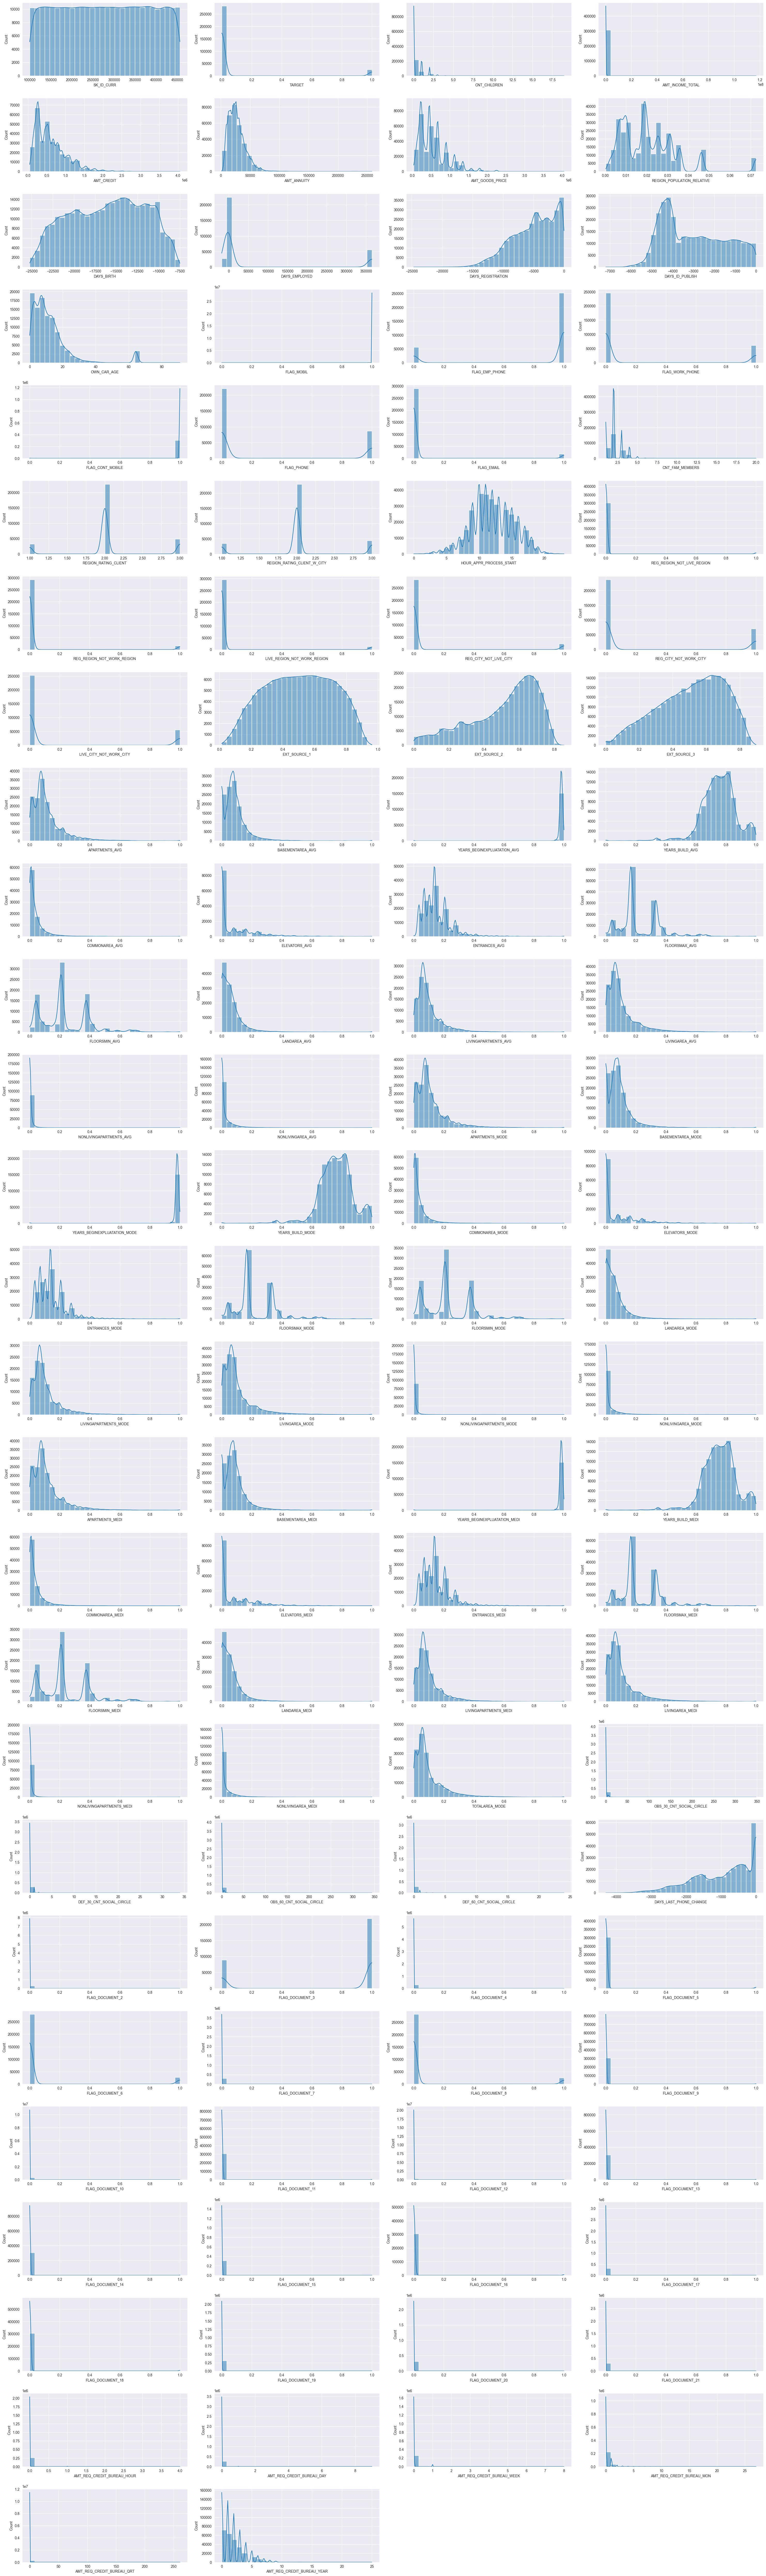

In [89]:
distribution(train_df_init, train_df_init.select_dtypes(exclude=['object']).columns, n_cols=4, nom='distribution.pdf',fig=(30,100))

Text(0.5, 1.0, 'Distribution of Ages')

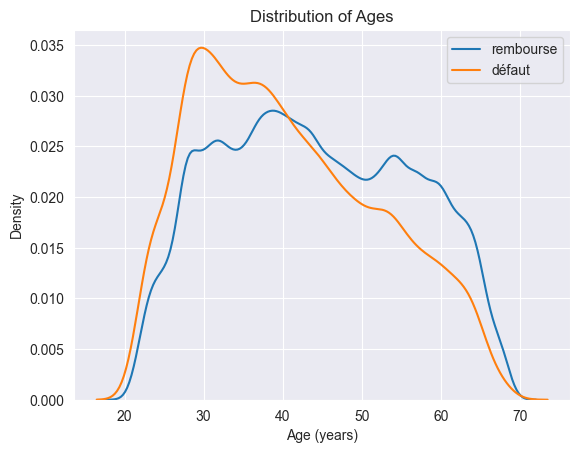

In [90]:
sns.kdeplot(train_df.loc[train_df['TARGET'] == 0, 'DAYS_BIRTH'], label = 'rembourse')
sns.kdeplot(train_df.loc[train_df['TARGET'] == 1, 'DAYS_BIRTH'], label = 'défaut')

plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.legend()
plt.title('Distribution of Ages')

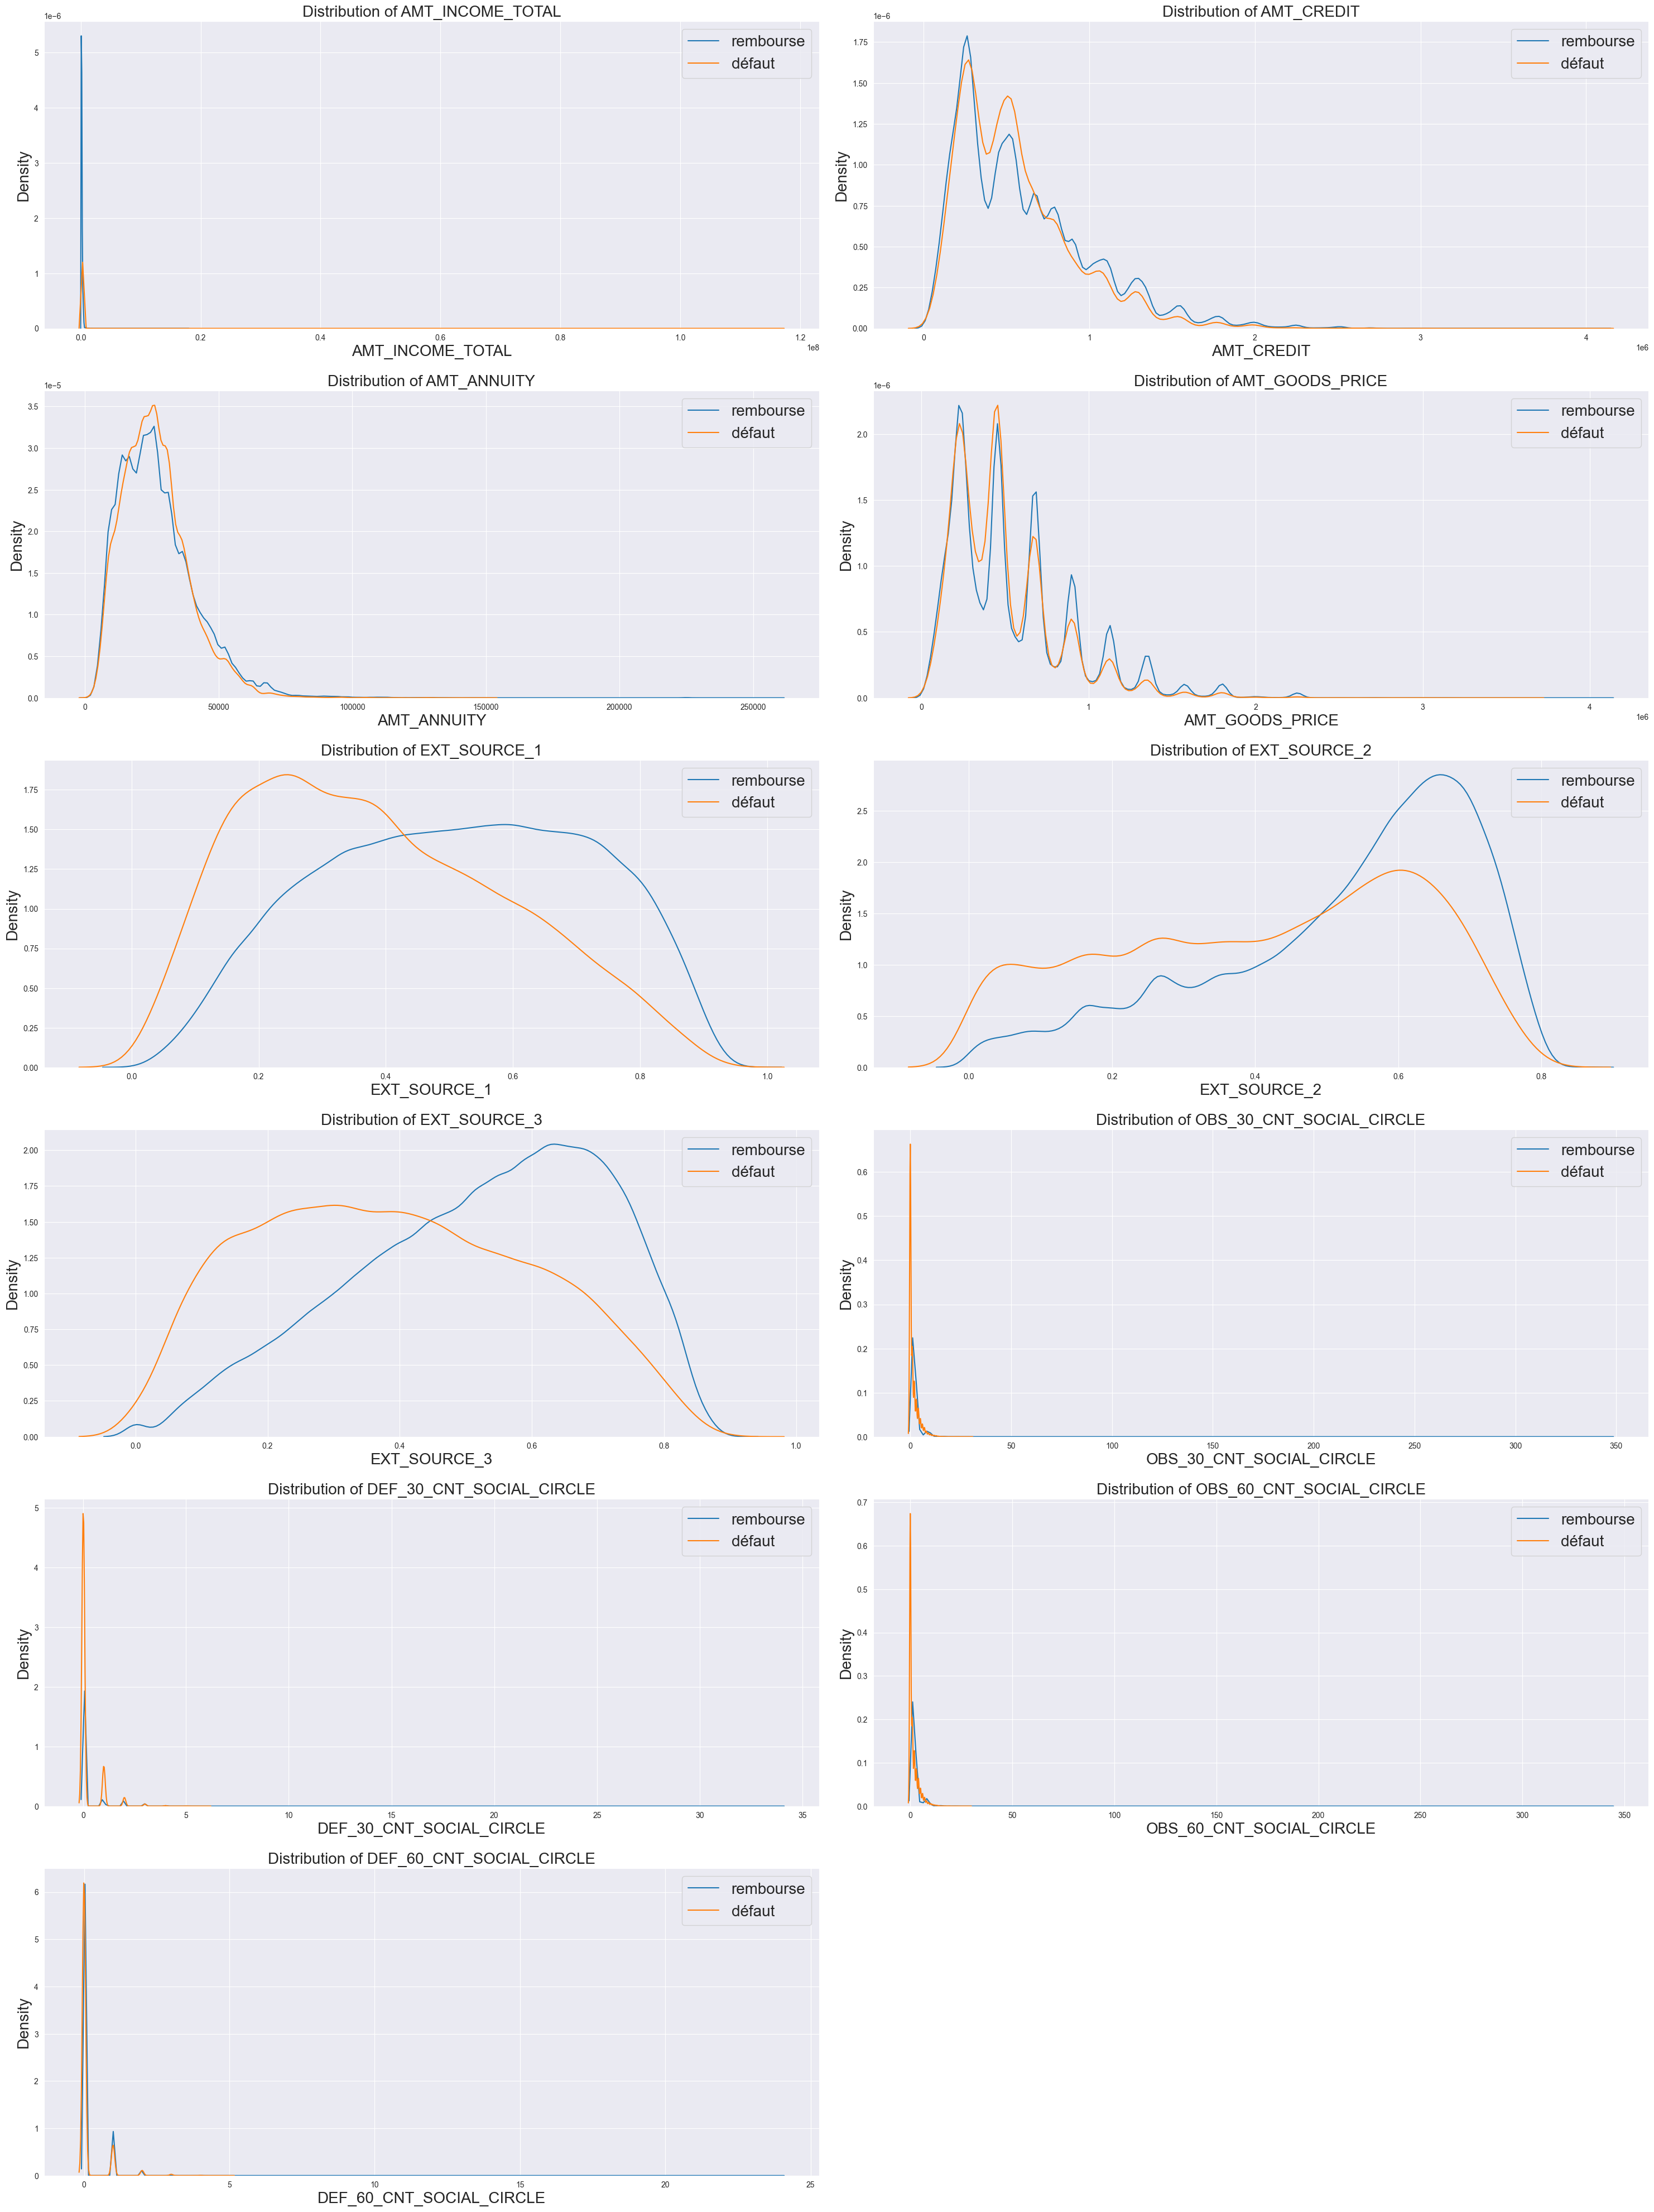

In [49]:
col_density = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
               'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','OBS_30_CNT_SOCIAL_CIRCLE',
               'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE']
distribution_densite(train_df_init,col_density,n_cols=2,nom='densite.pdf',fig=(30,40))

In [ ]:
col_quant = list(train_df_init.select_dtypes(['float64']).columns)
col_quant.append('TARGET')

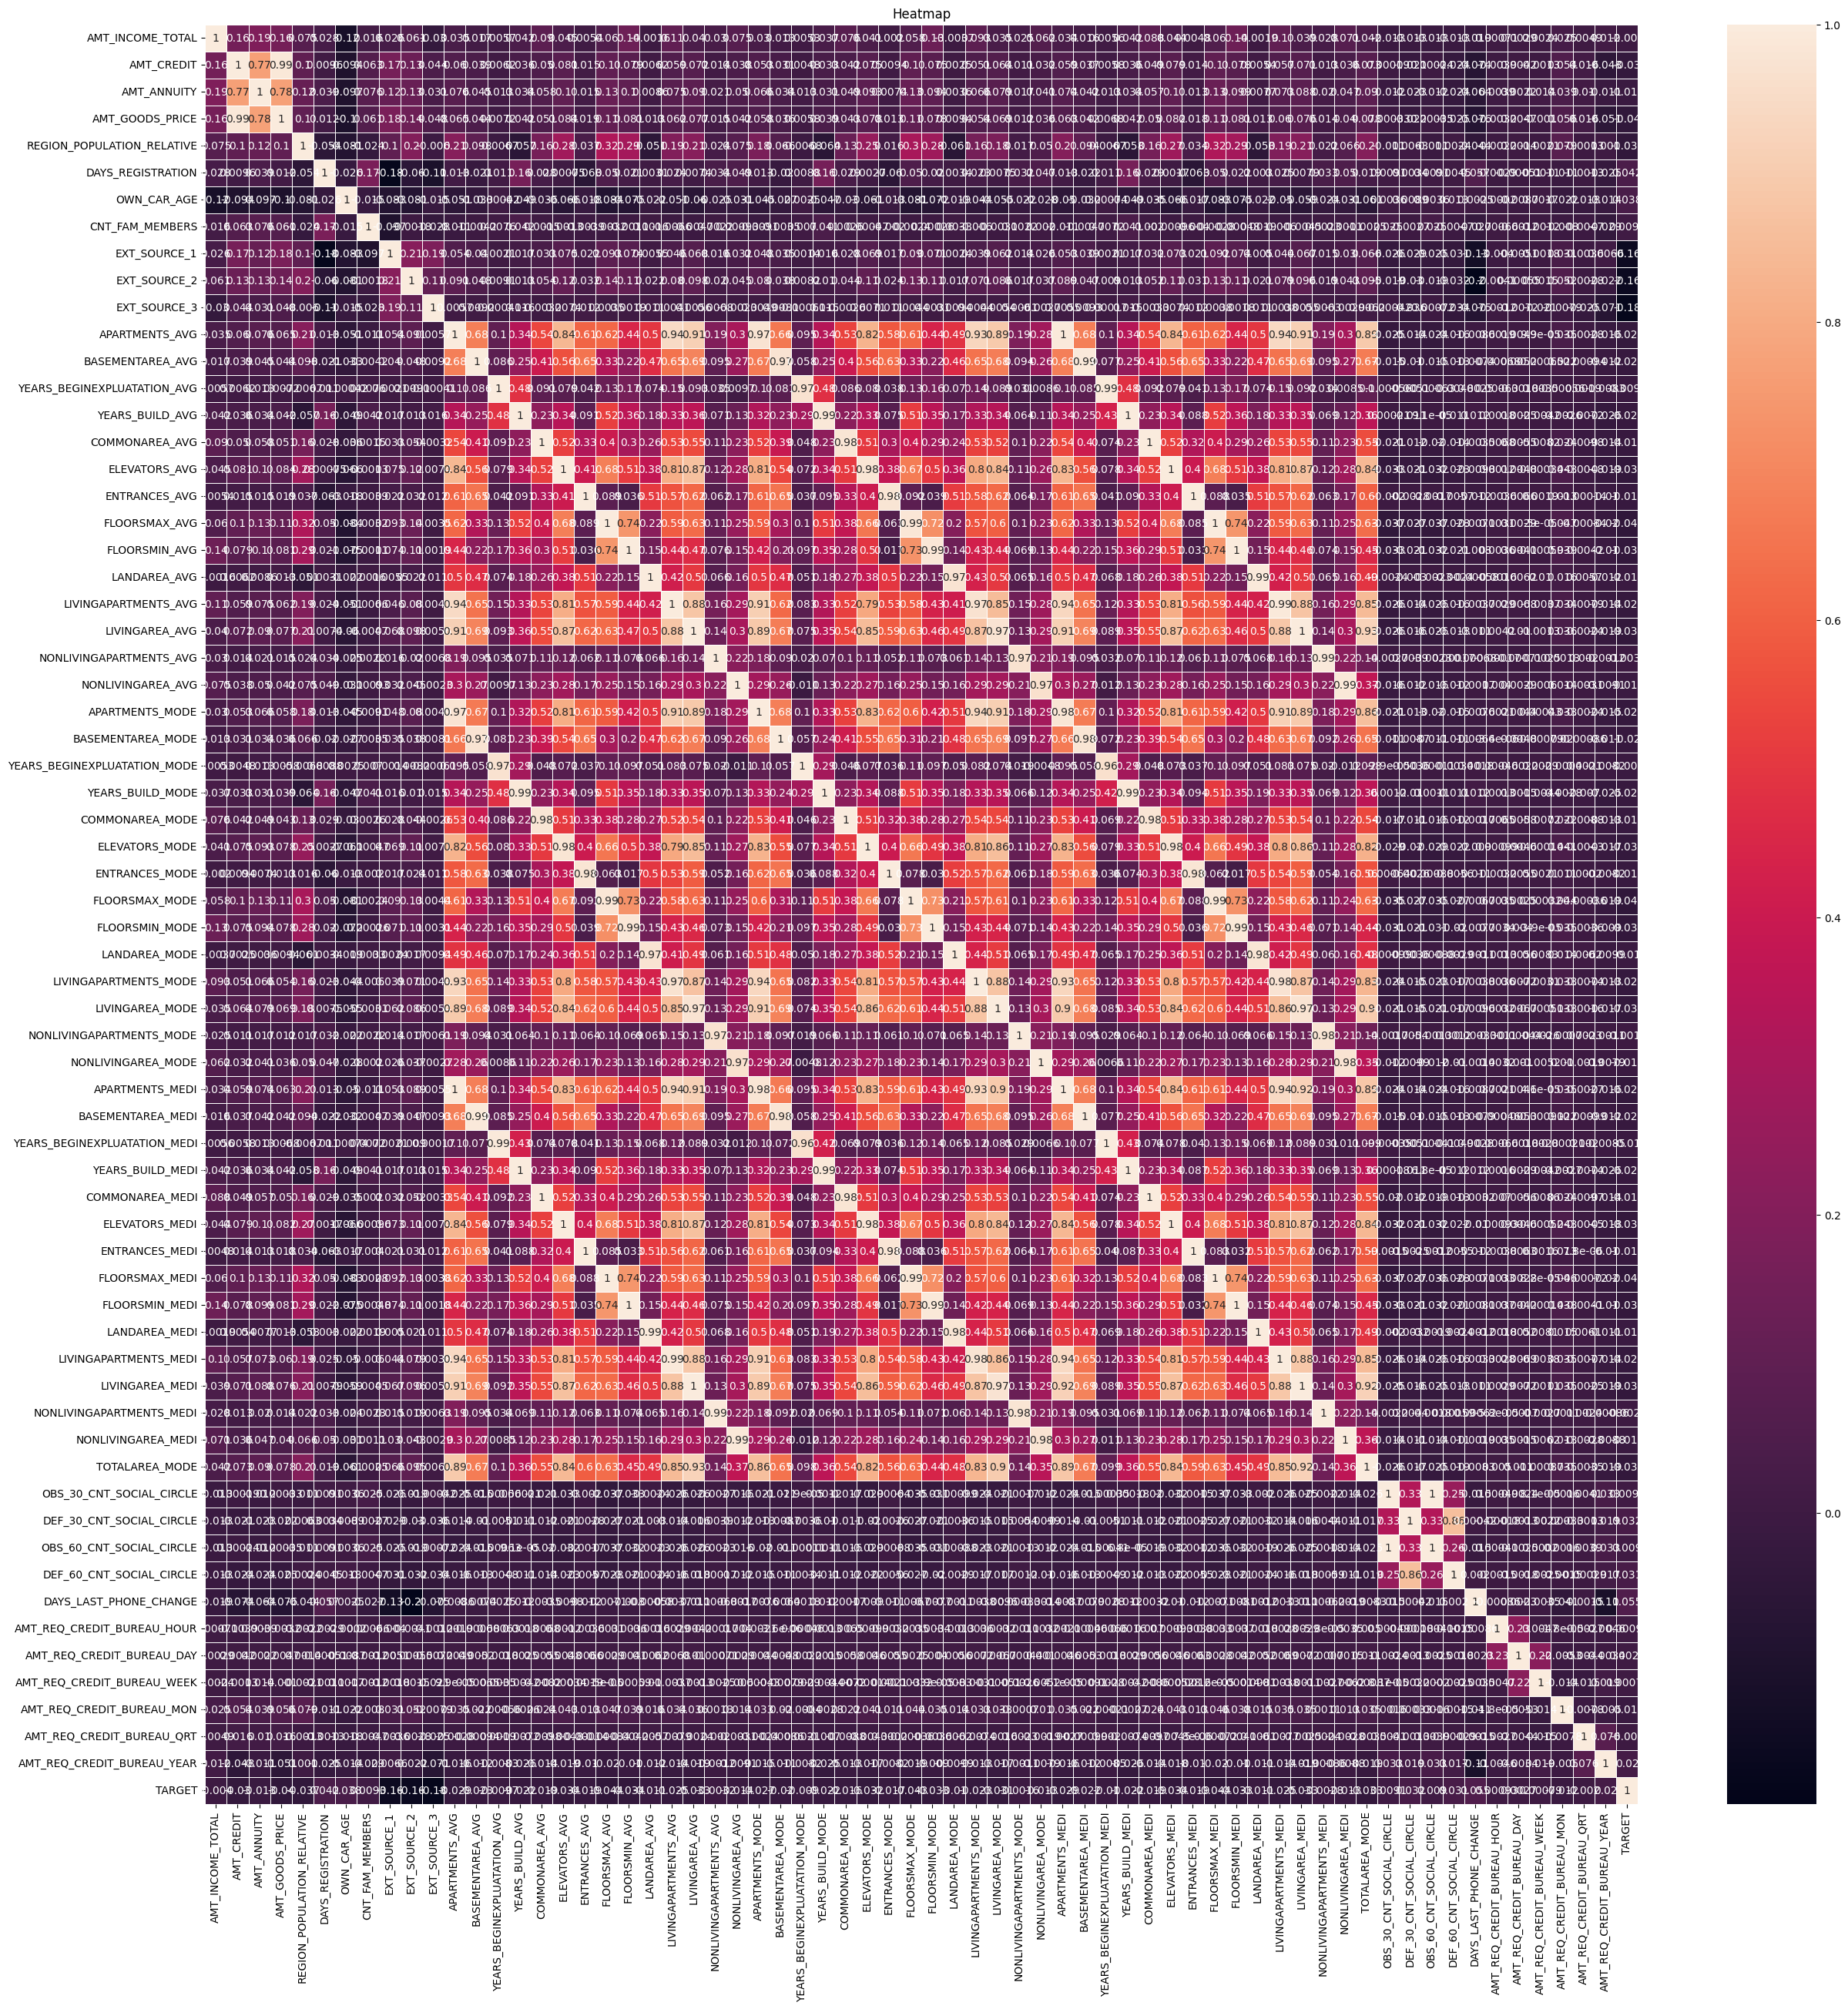

In [ ]:
df_corr = train_df_init[col_quant].corr()

heat_map(df_corr)

# Préparation pour la modélisation

In [54]:
# Nous devons retirer les caractères spéciaux des noms des features pour l'utilisation de certains modèles (LightGBM)
import re
train_df = train_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_df = test_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [55]:
X_train, X_val, y_train, y_val = train_test_split(train_df.drop(['TARGET','SK_ID_CURR'], axis = 1),
                                                    train_df['TARGET'],
                                                    test_size=0.2, random_state=42)


print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(246005, 559) (246005,)
(61502, 559) (61502,)


In [74]:
import os
import pickle

os.makedirs("Scoring/models", exist_ok=True)

pickle.dump(X_train, open('Scoring/models/X_train.pkl', 'wb'))
pickle.dump(y_train, open('Scoring/models/y_train.pkl', 'wb'))
pickle.dump(X_val, open('Scoring/models/X_val.pkl', 'wb'))
pickle.dump(y_val, open('Scoring/models/y_val.pkl', 'wb'))

In [75]:
X_val, X_val_test, y_val, y_val_test = train_test_split(X_val, y_val, test_size=0.20, stratify=y_val, random_state=0)

print(X_val_test.shape, y_val_test.shape)
print(X_val.shape, y_val.shape)

(6298, 559) (6298,)
(25190, 559) (25190,)


In [76]:
pickle.dump(X_val, open('Scoring/models/X_val.pkl', 'wb'))
pickle.dump(X_val_test, open('Scoring/models/X_val_test.pkl', 'wb'))
pickle.dump(y_val, open('Scoring/models/y_val.pkl', 'wb'))
pickle.dump(y_val_test, open('Scoring/models/y_val_test.pkl', 'wb'))

In [77]:
cols = X_train.select_dtypes(['float64']).columns

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_val_test_scaled = X_val_test.copy()
X_test_scaled = test_df.copy()

std_scale = StandardScaler()
std_scale.fit(X_train[cols])

X_train_scaled[cols] = std_scale.transform(X_train[cols])
X_val_scaled[cols] = std_scale.transform(X_val[cols])
X_val_test_scaled[cols] = std_scale.transform(X_val_test[cols])
#X_test_scaled[cols] = std_scale.transform(test_df[cols])

In [78]:
pickle.dump(X_train_scaled, open('models/X_train_scaled.pkl', 'wb'))
pickle.dump(X_val_scaled, open('models/X_val_scaled.pkl', 'wb'))
pickle.dump(X_val_test_scaled, open('models/X_val_test_scaled.pkl', 'wb'))
#pickle.dump(X_test_scaled, open('models/X_test_scaled.pkl', 'wb'))

In [81]:
X_train_scaled = pickle.load(open('models/X_train_scaled.pkl', 'rb'))
y_train = pickle.load(open('models/y_train.pkl', 'rb'))
X_val = pickle.load(open('models/X_val.pkl', 'rb'))
X_val_scaled = pickle.load(open('models/X_val_scaled.pkl', 'rb'))
y_val = pickle.load(open('models/y_val.pkl', 'rb'))
X_val_test = pickle.load(open('models/X_val_test.pkl', 'rb'))
X_val_test_scaled = pickle.load(open('models/X_val_test_scaled.pkl', 'rb'))
y_val_test = pickle.load(open('models/y_val_test.pkl', 'rb'))